In [70]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
download_list=os.listdir("Downloads/input")
print(download_list)

['sample_submission.csv', 'test', 'train']


In [71]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [72]:
filenames = os.listdir("Downloads/input/train/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)

In [73]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [74]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [75]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


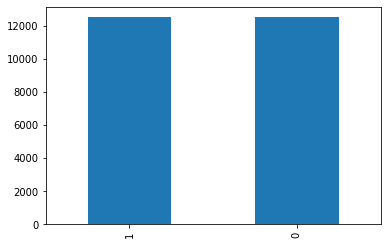

In [76]:
df['category'].value_counts().plot.bar()

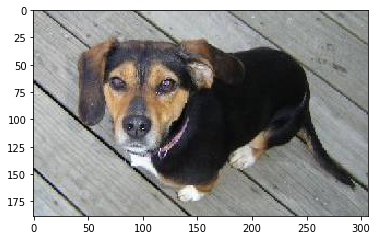

In [77]:
sample=random.choice(filenames)
image=load_img("Downloads/input/train/train/"+sample)
plt.imshow(image)

In [78]:
from keras.models import Sequential
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()


model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_5 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_6 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [80]:
earlystop=EarlyStopping(patience=10)

In [81]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [82]:
callbacks=[earlystop,learning_rate_reduction]

In [83]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [84]:
train_df, validate_df = train_test_split(df,train_size=500,test_size=500
                                         , random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

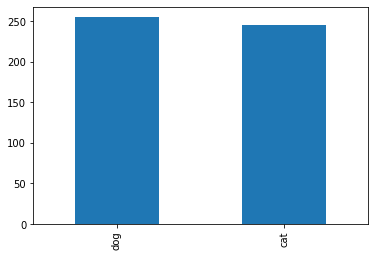

In [85]:
train_df['category'].value_counts().plot.bar()

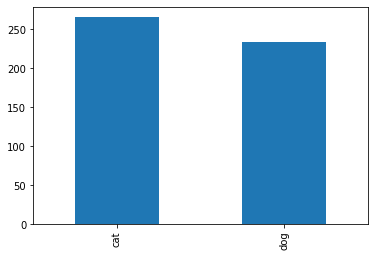

In [86]:
validate_df['category'].value_counts().plot.bar()

In [87]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [88]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [89]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "Downloads/input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 2 classes.


In [90]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Downloads/input/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 500 validated image filenames belonging to 2 classes.


In [91]:
epochs=5
history = model.fit_generator(
    train_generator, 
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
      epochs=epochs
)

Epoch 1/5
33/33 [==============================] - 66s 2s/step - loss: 1.6762 - acc: 0.5333 - val_loss: 2.6172 - val_acc: 0.5434
Epoch 2/5
33/33 [==============================] - 59s 2s/step - loss: 1.2070 - acc: 0.5716 - val_loss: 1.4791 - val_acc: 0.5897
Epoch 3/5
33/33 [==============================] - 60s 2s/step - loss: 1.0350 - acc: 0.5897 - val_loss: 1.3609 - val_acc: 0.5258
Epoch 4/5
33/33 [==============================] - 60s 2s/step - loss: 0.9541 - acc: 0.6140 - val_loss: 1.6256 - val_acc: 0.5278

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/5
33/33 [==============================] - 59s 2s/step - loss: 0.9107 - acc: 0.5819 - val_loss: 1.0560 - val_acc: 0.5753


In [92]:
test_filenames = os.listdir("Downloads/input/test/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [93]:
test_df.head()

,filename
0,1.jpg
1,10.jpg
2,100.jpg
3,1000.jpg
4,10000.jpg


In [94]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "Downloads/input/test/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


In [95]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

In [96]:
predict

array([[0.64443827, 0.35556167],
       [0.69792753, 0.3020725 ],
       [0.8391261 , 0.16087385],
       ...,
       [0.9516087 , 0.04839131],
       [0.97832036, 0.02167967],
       [0.6440115 , 0.35598853]], dtype=float32)

In [97]:
test_df['category'] = np.argmax(predict, axis=-1)

In [105]:
test_df['category'].head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     1
9     0
10    0
11    0
12    0
13    0
14    1
15    1
16    1
17    0
18    0
19    1
Name: category, dtype: int64

In [99]:
# label_map = dict((v,k) for k,v in train_generator.class_indices.items())

# label_map

In [100]:
# test_df['category'] = test_df['category'].replace(label_map)
# test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

# test_df['category'].value_counts().plot.bar()

In [101]:
# sample_test = test_df.head(18)
# sample_test.head()
# plt.figure(figsize=(12, 24))
# for index, row in sample_test.iterrows():
#     filename = row['filename']
#     category = row['category']
#     img = load_img("Downloads/input/test/test/"+filename, target_size=IMAGE_SIZE)
#     plt.subplot(6, 3, index+1)
#     plt.imshow(img)
#     plt.xlabel(filename + '(' + "{}".format(category) + ')' )
# plt.tight_layout()
# plt.show()

In [106]:
submission=pd.DataFrame({'id':test_df['filename'].str.split('.').str[0],'label':test_df['category']})
submission.to_csv('submission15.csv', index=False)

In [107]:
submission.head(20)

,id,label
0,1,0
1,10,0
2,100,0
3,1000,0
4,10000,0
5,10001,0
6,10002,1
7,10003,1
8,10004,1
9,10005,0
